Loading G6solar data...
G6solar shape: (1020, 192, 384)
Loading G6sulfur data...
G6sulfur shape: (960, 192, 384)

G6SULFUR vs G6SOLAR PERFORMANCE COMPARISON

Method          G6sulfur RMSE         G6solar RMSE          Difference     
------------------------------------------------------------------------
Bilinear            2.8083               2.7484        -0.0600
QDM                 2.5977               2.4951        -0.1026
MLd                 2.5989               2.4018        -0.1970
MLs                 2.1566               2.0330        -0.1236

Method           G6sulfur R²           G6solar R²           Difference     
------------------------------------------------------------------------
Bilinear            0.9800               0.9811        +0.0011
QDM                 0.9822               0.9838        +0.0016
MLd                 0.9830               0.9857        +0.0027
MLs                 0.9884               0.9898        +0.0014


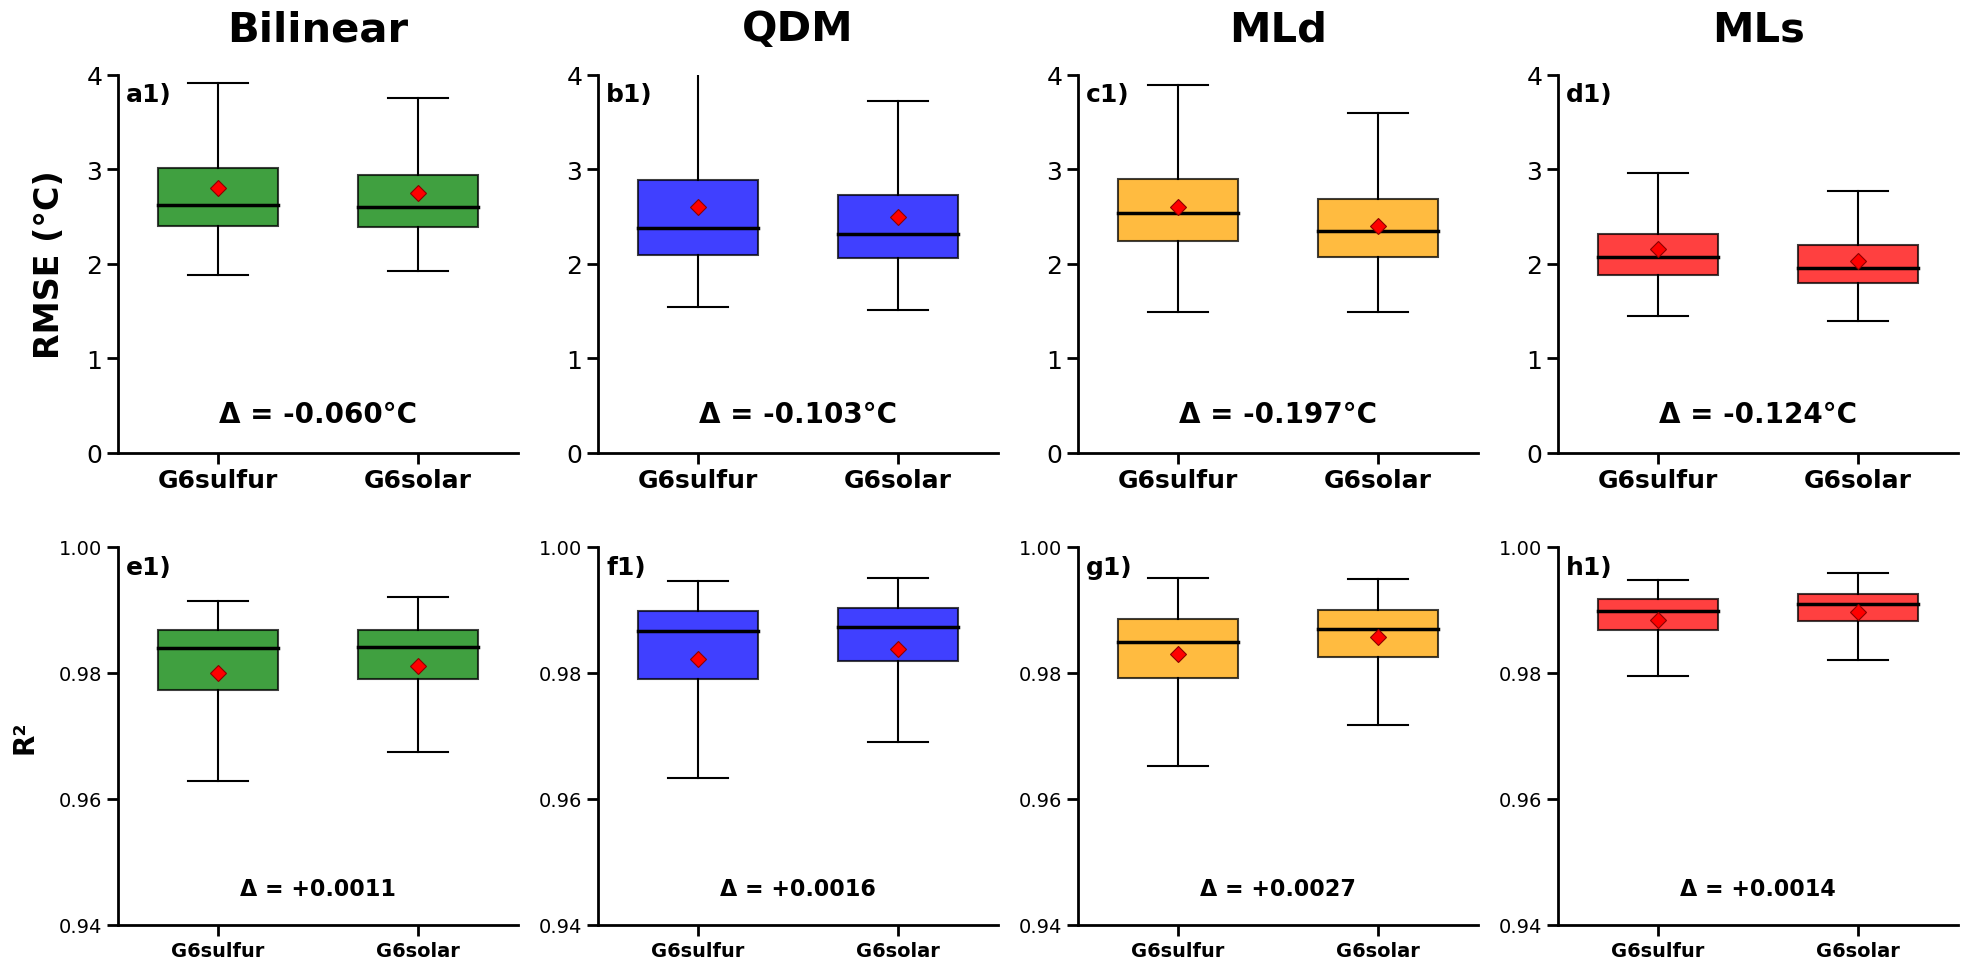

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path

# ----------------------------
# Configuration
# ----------------------------
data_dir = Path("../data")
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")
figures_dir.mkdir(exist_ok=True)

# Colors for models
model_colors = {
    'bilinear': 'green',    
    'qdm': 'blue',        
    'mld': 'orange',        
    'mls': 'red'      
}

# ----------------------------
# Load G6solar results
# ----------------------------
print("Loading G6solar data...")
ds_g6solar_main = xr.open_dataset(data_dir / "g6solar_downscaled_results.nc")
ds_g6solar_qdm = xr.open_dataset(results_dir / "tas_evaluation_g6solar_qdm.nc")

g6solar_gt = ds_g6solar_main['groundtruth'].values
g6solar_input = ds_g6solar_main['input'].values
g6solar_mld = ds_g6solar_main['pred_zscore_pixel'].values
g6solar_mls = ds_g6solar_main['pred_grid'].values
g6solar_qdm = ds_g6solar_qdm['pred_qdm'].values

print(f"G6solar shape: {g6solar_gt.shape}")

# ----------------------------
# Load G6sulfur results
# ----------------------------
print("Loading G6sulfur data...")
ds_g6sulfur_main = xr.open_dataset(results_dir / "tas_evaluation_g6sulfur.nc")
ds_g6sulfur_residual = xr.open_dataset(results_residual_dir / "tas_evaluation_g6sulfur.nc")
ds_g6sulfur_qdm = xr.open_dataset(results_dir / "tas_evaluation_g6sulfur_qdm.nc")

g6sulfur_gt = ds_g6sulfur_main['groundtruth'].values
g6sulfur_input = ds_g6sulfur_main['input'].values
g6sulfur_mld = ds_g6sulfur_main['pred_zscore_pixel'].values
g6sulfur_mls = ds_g6sulfur_residual['pred_grid'].values
g6sulfur_qdm = ds_g6sulfur_qdm['pred_qdm'].values

print(f"G6sulfur shape: {g6sulfur_gt.shape}")

# ----------------------------
# Functions
# ----------------------------
def compute_spatial_rmse_timeseries(predictions, reference):
    """Calculate spatial RMSE for each time point."""
    n_time = predictions.shape[0]
    rmse_values = []
    for t in range(n_time):
        pred_2d = predictions[t].flatten()
        ref_2d = reference[t].flatten()
        rmse = np.sqrt(np.mean((pred_2d - ref_2d)**2))
        rmse_values.append(rmse)
    return np.array(rmse_values)

def compute_spatial_r2_timeseries(predictions, reference):
    """Calculate spatial R² for each time point."""
    n_time = predictions.shape[0]
    r2_values = []
    for t in range(n_time):
        pred_2d = predictions[t].flatten()
        ref_2d = reference[t].flatten()
        ss_res = np.sum((ref_2d - pred_2d)**2)
        ss_tot = np.sum((ref_2d - np.mean(ref_2d))**2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        r2_values.append(r2)
    return np.array(r2_values)

# ----------------------------
# Compute metrics
# ----------------------------
models = ['bilinear', 'qdm', 'mld', 'mls']
model_labels = ['Bilinear', 'QDM', 'MLd', 'MLs']

# G6sulfur metrics
g6sulfur_rmse = {
    'bilinear': compute_spatial_rmse_timeseries(g6sulfur_input, g6sulfur_gt),
    'qdm': compute_spatial_rmse_timeseries(g6sulfur_qdm, g6sulfur_gt),
    'mld': compute_spatial_rmse_timeseries(g6sulfur_mld, g6sulfur_gt),
    'mls': compute_spatial_rmse_timeseries(g6sulfur_mls, g6sulfur_gt)
}

g6sulfur_r2 = {
    'bilinear': compute_spatial_r2_timeseries(g6sulfur_input, g6sulfur_gt),
    'qdm': compute_spatial_r2_timeseries(g6sulfur_qdm, g6sulfur_gt),
    'mld': compute_spatial_r2_timeseries(g6sulfur_mld, g6sulfur_gt),
    'mls': compute_spatial_r2_timeseries(g6sulfur_mls, g6sulfur_gt)
}

# G6solar metrics
g6solar_rmse = {
    'bilinear': compute_spatial_rmse_timeseries(g6solar_input, g6solar_gt),
    'qdm': compute_spatial_rmse_timeseries(g6solar_qdm, g6solar_gt),
    'mld': compute_spatial_rmse_timeseries(g6solar_mld, g6solar_gt),
    'mls': compute_spatial_rmse_timeseries(g6solar_mls, g6solar_gt)
}

g6solar_r2 = {
    'bilinear': compute_spatial_r2_timeseries(g6solar_input, g6solar_gt),
    'qdm': compute_spatial_r2_timeseries(g6solar_qdm, g6solar_gt),
    'mld': compute_spatial_r2_timeseries(g6solar_mld, g6solar_gt),
    'mls': compute_spatial_r2_timeseries(g6solar_mls, g6solar_gt)
}

# ----------------------------
# Print comparison table
# ----------------------------
print("\n" + "="*80)
print("G6SULFUR vs G6SOLAR PERFORMANCE COMPARISON")
print("="*80)

print("\n{:<12} {:^20} {:^20} {:^20}".format(
    "Method", "G6sulfur RMSE", "G6solar RMSE", "Difference"))
print("-"*72)
for model, label in zip(models, model_labels):
    sulfur_mean = np.mean(g6sulfur_rmse[model])
    solar_mean = np.mean(g6solar_rmse[model])
    diff = solar_mean - sulfur_mean
    print(f"{label:<12} {sulfur_mean:^20.4f} {solar_mean:^20.4f} {diff:+.4f}")

print("\n{:<12} {:^20} {:^20} {:^20}".format(
    "Method", "G6sulfur R²", "G6solar R²", "Difference"))
print("-"*72)
for model, label in zip(models, model_labels):
    sulfur_mean = np.mean(g6sulfur_r2[model])
    solar_mean = np.mean(g6solar_r2[model])
    diff = solar_mean - sulfur_mean
    print(f"{label:<12} {sulfur_mean:^20.4f} {solar_mean:^20.4f} {diff:+.4f}")

# ----------------------------
# Y-axis configuration
# ----------------------------
y_axis_config = {
    'rmse': {'lim': (0, 4), 'ticks': [0, 1, 2, 3, 4]},
    'r2': {'lim': (0.94, 1.0), 'ticks': [0.94, 0.96, 0.98, 1.0]}
}

# Panel labels
panel_labels_row1 = ['a1)', 'b1)', 'c1)', 'd1)']
panel_labels_row2 = ['e1)', 'f1)', 'g1)', 'h1)']

# ----------------------------
# Create Figure 1: Boxplots (2x4)
# ----------------------------
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Row 1: RMSE comparison for each method
for i, (model, label) in enumerate(zip(models, model_labels)):
    ax = axes[0, i]
    
    box_data = [g6sulfur_rmse[model], g6solar_rmse[model]]
    positions = [1, 2]
    color = model_colors[model]
    
    bp = ax.boxplot(box_data, positions=positions, widths=0.6,
                    patch_artist=True, showfliers=False,
                    medianprops=dict(color='black', linewidth=2.5),
                    boxprops=dict(linewidth=1.5),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))
    
    for patch in bp['boxes']:
        patch.set_facecolor(color)
        patch.set_alpha(0.75)
    
    # Add mean markers
    for j, data in enumerate(box_data):
        ax.plot(positions[j], np.mean(data), 'D', color='red', 
                markersize=8, zorder=10, markeredgecolor='darkred', 
                markeredgewidth=0.8)
    
    # Add difference annotation at lower center
    diff = np.mean(g6solar_rmse[model]) - np.mean(g6sulfur_rmse[model])
    y_range = y_axis_config['rmse']['lim'][1] - y_axis_config['rmse']['lim'][0]
    ax.text(1.5, y_axis_config['rmse']['lim'][0] + y_range * 0.08, f'Δ = {diff:+.3f}°C', 
            ha='center', fontsize=20, fontweight='bold', color='black')
    
    ax.set_xticks(positions)
    ax.set_xticklabels(['G6sulfur', 'G6solar'], fontsize=24, fontweight='bold')
    
    ax.set_ylim(y_axis_config['rmse']['lim'])
    ax.set_yticks(y_axis_config['rmse']['ticks'])
    
    if i == 0:
        ax.set_ylabel('RMSE (°C)', fontsize=24, fontweight='bold', labelpad=15)
    
    ax.set_title(f'{label}', fontsize=30, fontweight='bold', pad=25)
    ax.text(0.02, 0.98, panel_labels_row1[i], transform=ax.transAxes, 
            fontsize=18, fontweight='bold', va='top')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.tick_params(axis='both', which='major', labelsize=18, length=8, width=2, colors='black')

# Row 2: R² comparison for each method
for i, (model, label) in enumerate(zip(models, model_labels)):
    ax = axes[1, i]
    
    box_data = [g6sulfur_r2[model], g6solar_r2[model]]
    positions = [1, 2]
    color = model_colors[model]
    
    bp = ax.boxplot(box_data, positions=positions, widths=0.6,
                    patch_artist=True, showfliers=False,
                    medianprops=dict(color='black', linewidth=2.5),
                    boxprops=dict(linewidth=1.5),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))
    
    for patch in bp['boxes']:
        patch.set_facecolor(color)
        patch.set_alpha(0.75)
    
    # Add mean markers
    for j, data in enumerate(box_data):
        ax.plot(positions[j], np.mean(data), 'D', color='red', 
                markersize=8, zorder=10, markeredgecolor='darkred', 
                markeredgewidth=0.8)
    
    # Add difference annotation at lower center
    diff = np.mean(g6solar_r2[model]) - np.mean(g6sulfur_r2[model])
    y_range = y_axis_config['r2']['lim'][1] - y_axis_config['r2']['lim'][0]
    ax.text(1.5, y_axis_config['r2']['lim'][0] + y_range * 0.08, f'Δ = {diff:+.4f}', 
            ha='center', fontsize=16, fontweight='bold', color='black')
    
    ax.set_xticks(positions)
    ax.set_xticklabels(['G6sulfur', 'G6solar'], fontsize=16, fontweight='bold')
    
    ax.set_ylim(y_axis_config['r2']['lim'])
    ax.set_yticks(y_axis_config['r2']['ticks'])
    
    if i == 0:
        ax.set_ylabel('R²', fontsize=20, fontweight='bold', labelpad=15)
    
    ax.text(0.02, 0.98, panel_labels_row2[i], transform=ax.transAxes, 
            fontsize=18, fontweight='bold', va='top')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.tick_params(axis='both', which='major', labelsize=14, length=8, width=2, colors='black')

plt.subplots_adjust(hspace=0.25, wspace=0.2, left=0.06, right=0.98, top=0.93, bottom=0.08)
plt.savefig(figures_dir / "g6sulfur_vs_g6solar_boxplots.png", dpi=300, bbox_inches='tight')
plt.show()


Loading G6solar data...
G6solar shape: (1020, 192, 384)
Loading G6sulfur data...
G6sulfur shape: (960, 192, 384)

Computing biases...


/tmp/ipykernel_67568/371397618.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.15, 1.0, 1.0], h_pad=1.5, w_pad=0.5)


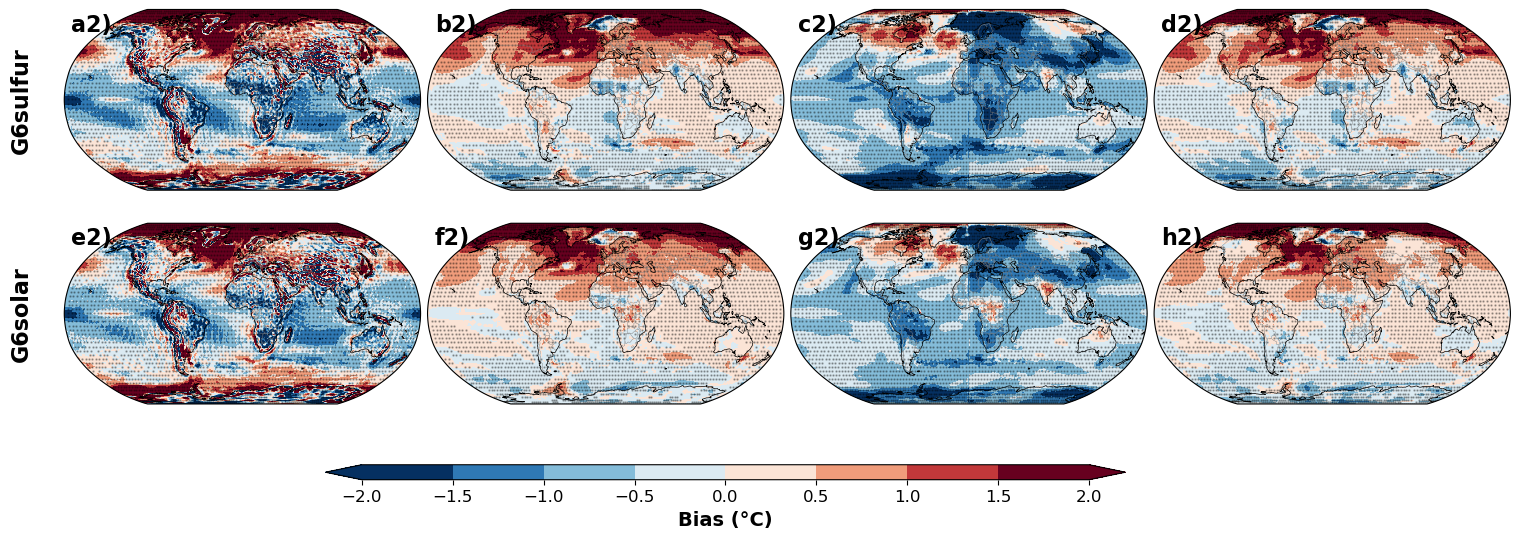

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from scipy import stats

# ----------------------------
# Configuration
# ----------------------------
data_dir = Path("../data")
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")
figures_dir.mkdir(exist_ok=True)

# Significance level
alpha = 0.05

# ----------------------------
# Load G6solar results
# ----------------------------
print("Loading G6solar data...")
ds_g6solar_main = xr.open_dataset(data_dir / "g6solar_downscaled_results.nc")
ds_g6solar_qdm = xr.open_dataset(results_dir / "tas_evaluation_g6solar_qdm.nc")

g6solar_gt = ds_g6solar_main['groundtruth'].values
g6solar_input = ds_g6solar_main['input'].values
g6solar_mld = ds_g6solar_main['pred_zscore_pixel'].values
g6solar_mls = ds_g6solar_main['pred_grid'].values
g6solar_qdm = ds_g6solar_qdm['pred_qdm'].values

lat = ds_g6solar_main['groundtruth'].lat.values
lon_original = ds_g6solar_main['groundtruth'].lon.values

print(f"G6solar shape: {g6solar_gt.shape}")

# ----------------------------
# Load G6sulfur results
# ----------------------------
print("Loading G6sulfur data...")
ds_g6sulfur_main = xr.open_dataset(results_dir / "tas_evaluation_g6sulfur.nc")
ds_g6sulfur_residual = xr.open_dataset(results_residual_dir / "tas_evaluation_g6sulfur.nc")
ds_g6sulfur_qdm = xr.open_dataset(results_dir / "tas_evaluation_g6sulfur_qdm.nc")

g6sulfur_gt = ds_g6sulfur_main['groundtruth'].values
g6sulfur_input = ds_g6sulfur_main['input'].values
g6sulfur_mld = ds_g6sulfur_main['pred_zscore_pixel'].values
g6sulfur_mls = ds_g6sulfur_residual['pred_grid'].values
g6sulfur_qdm = ds_g6sulfur_qdm['pred_qdm'].values

print(f"G6sulfur shape: {g6sulfur_gt.shape}")

# ----------------------------
# Functions
# ----------------------------
def shift_data_longitude(data, lon):
    """Shift data and longitude from [0, 360] to [-180, 180]."""
    lon_shifted = np.where(lon > 180, lon - 360, lon)
    split_idx = np.searchsorted(lon, 180.0)
    
    if data.ndim == 2:
        data_shifted = np.roll(data, -split_idx, axis=1)
    elif data.ndim == 3:
        data_shifted = np.roll(data, -split_idx, axis=2)
    else:
        raise ValueError(f"Unexpected data dimensions: {data.ndim}")
    
    lon_shifted = np.roll(lon_shifted, -split_idx)
    return data_shifted, lon_shifted

def calculate_mean_bias(pred_data, truth_data):
    """Calculate mean bias (prediction - truth) over all time steps."""
    bias = pred_data - truth_data
    mean_bias = np.mean(bias, axis=0)
    return mean_bias

def calculate_significance(pred_data, truth_data, alpha=0.05):
    """Calculate statistical significance of bias using t-test."""
    bias = pred_data - truth_data
    t_stat, p_values = stats.ttest_1samp(bias, 0, axis=0)
    significant = p_values < alpha
    return significant

# ----------------------------
# Compute biases
# ----------------------------
models = ['bilinear', 'qdm', 'mld', 'mls']
model_labels = ['Bilinear', 'QDM', 'MLd', 'MLs']

print("\nComputing biases...")

# G6sulfur biases
g6sulfur_biases = {
    'bilinear': calculate_mean_bias(g6sulfur_input, g6sulfur_gt),
    'qdm': calculate_mean_bias(g6sulfur_qdm, g6sulfur_gt),
    'mld': calculate_mean_bias(g6sulfur_mld, g6sulfur_gt),
    'mls': calculate_mean_bias(g6sulfur_mls, g6sulfur_gt)
}

g6sulfur_significance = {
    'bilinear': calculate_significance(g6sulfur_input, g6sulfur_gt, alpha),
    'qdm': calculate_significance(g6sulfur_qdm, g6sulfur_gt, alpha),
    'mld': calculate_significance(g6sulfur_mld, g6sulfur_gt, alpha),
    'mls': calculate_significance(g6sulfur_mls, g6sulfur_gt, alpha)
}

# G6solar biases
g6solar_biases = {
    'bilinear': calculate_mean_bias(g6solar_input, g6solar_gt),
    'qdm': calculate_mean_bias(g6solar_qdm, g6solar_gt),
    'mld': calculate_mean_bias(g6solar_mld, g6solar_gt),
    'mls': calculate_mean_bias(g6solar_mls, g6solar_gt)
}

g6solar_significance = {
    'bilinear': calculate_significance(g6solar_input, g6solar_gt, alpha),
    'qdm': calculate_significance(g6solar_qdm, g6solar_gt, alpha),
    'mld': calculate_significance(g6solar_mld, g6solar_gt, alpha),
    'mls': calculate_significance(g6solar_mls, g6solar_gt, alpha)
}

# Shift longitude for plotting
_, lon = shift_data_longitude(g6sulfur_biases['bilinear'], lon_original)

# ----------------------------
# Colormap settings
# ----------------------------
cmap = 'RdBu_r'
bias_vmin, bias_vmax = -2, 2
bias_levels = np.linspace(bias_vmin, bias_vmax, 9)
bias_norm = BoundaryNorm(bias_levels, ncolors=256)

# Panel labels
panel_labels_row1 = ['a2)', 'b2)', 'c2)', 'd2)']
panel_labels_row2 = ['e2)', 'f2)', 'g2)', 'h2)']

# ----------------------------
# Create Figure 2: Bias Maps (2x4)
# ----------------------------
fig = plt.figure(figsize=(16, 6))

lon_2d, lat_2d = np.meshgrid(lon, lat)

# Row 1: G6sulfur bias maps
for i, (model, label) in enumerate(zip(models, model_labels)):
    ax = fig.add_subplot(2, 4, i + 1, projection=ccrs.Robinson())
    
    # Shift bias data
    bias_shifted, _ = shift_data_longitude(g6sulfur_biases[model], lon_original)
    sig_shifted, _ = shift_data_longitude(g6sulfur_significance[model].astype(float), lon_original)
    sig_shifted = sig_shifted.astype(bool)
    
    # Plot bias
    im = ax.pcolormesh(lon_2d, lat_2d, bias_shifted,
                       transform=ccrs.PlateCarree(),
                       cmap=cmap, norm=bias_norm,
                       shading='auto')
    
    # Add stippling for significant areas
    lat_sub = lat[::4]
    lon_sub = lon[::4]
    sig_sub = sig_shifted[::4, ::4]
    lon_sub_2d, lat_sub_2d = np.meshgrid(lon_sub, lat_sub)
    
    ax.scatter(lon_sub_2d[sig_sub], lat_sub_2d[sig_sub],
               s=0.5, c='black', alpha=0.3,
               transform=ccrs.PlateCarree(),
               rasterized=True)
    
    ax.coastlines(linewidth=0.5, color='black')
    ax.add_feature(cfeature.BORDERS, linewidth=0.3, edgecolor='gray')
    ax.set_global()
    
    # Row label (first column)
    if i == 0:
        ax.text(-0.12, 0.5, 'G6sulfur', 
                transform=ax.transAxes,
                fontsize=16, fontweight='bold',
                rotation=90, va='center', ha='center')
    
    ax.text(0.02, 0.98, panel_labels_row1[i], transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', color='black')

# Row 2: G6solar bias maps
for i, (model, label) in enumerate(zip(models, model_labels)):
    ax = fig.add_subplot(2, 4, i + 5, projection=ccrs.Robinson())
    
    # Shift bias data
    bias_shifted, _ = shift_data_longitude(g6solar_biases[model], lon_original)
    sig_shifted, _ = shift_data_longitude(g6solar_significance[model].astype(float), lon_original)
    sig_shifted = sig_shifted.astype(bool)
    
    # Plot bias
    im = ax.pcolormesh(lon_2d, lat_2d, bias_shifted,
                       transform=ccrs.PlateCarree(),
                       cmap=cmap, norm=bias_norm,
                       shading='auto')
    
    # Add stippling for significant areas
    lat_sub = lat[::4]
    lon_sub = lon[::4]
    sig_sub = sig_shifted[::4, ::4]
    lon_sub_2d, lat_sub_2d = np.meshgrid(lon_sub, lat_sub)
    
    ax.scatter(lon_sub_2d[sig_sub], lat_sub_2d[sig_sub],
               s=0.5, c='black', alpha=0.3,
               transform=ccrs.PlateCarree(),
               rasterized=True)
    
    ax.coastlines(linewidth=0.5, color='black')
    ax.add_feature(cfeature.BORDERS, linewidth=0.3, edgecolor='gray')
    ax.set_global()
    
    # Row label (first column)
    if i == 0:
        ax.text(-0.12, 0.5, 'G6solar', 
                transform=ax.transAxes,
                fontsize=16, fontweight='bold',
                rotation=90, va='center', ha='center')
    
    ax.text(0.02, 0.98, panel_labels_row2[i], transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', color='black')

# Add colorbar closer to panels
cbar_ax = fig.add_axes([0.25, 0.12, 0.5, 0.025])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('Bias (°C)', fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0.05, 0.15, 1.0, 1.0], h_pad=1.5, w_pad=0.5)
plt.savefig(figures_dir / "g6sulfur_vs_g6solar_bias_maps.png", dpi=300, bbox_inches='tight')
plt.show()
